<a href="https://colab.research.google.com/github/shiroikenshi/texture-synthesis-ip-project/blob/main/Texture_Synthesis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Processamento de Imagens

### 1º Semestre de 2023
<br></br>

# Relatório do Projeto

## Felipe Pinto da Silva


---
# Melhorando imagens com técnicas de Texture Synthesis
---


## Resumo

O tema do projeto tem como objetivo melhorar a qualidade visual de imagens danificadas ou com baixa resolução através da implementação de técnicas da Síntese de Textura. Isso foi feito atráves de funções do OpenCV e de um modelo treinado de IA.

### Prévia de resultados:
<img src="https://raw.githubusercontent.com/shiroikenshi/Texture-Systhesis-Imagens/main/Prévias/previa1.png">

A primeira imagem apresenta defeitos e baixa resolução, na seguinte imagem as imperfeições são corrigidas e há o aumento da resolução.

Na implementação dos algoritmos a imagem sofreu um upscale, devido alguns parametros adicionais na execução do script da rede neural, tornou-se possível recuperar detalhes anteriormente perdidos do rosto.

## Introdução

O tema escolhido foi a Síntese de Texturas, em uma rápida definição se trata de uma tecnica computacional que tem como objetivo criar novas texturas a partir de uma amostra existente. Isso é feito através de algoritmos que analisam a textura original e a reproduzem de forma coerente em uma área maior ou menor, dependendo da necessidade.

Nesse projeto vamos implementar dois algoritmos de síntese de Textura:

1. Inpainting - Técnica de processamento de imagens que permite remover ou preencher áreas faltantes ou danificadas em uma imagem, de forma a reconstruir a informação perdida.
2. Super-resolução com rede neural - Técnica de processamento de imagens que permite aumentar a resolução de uma imagem, de forma a obter uma versão mais detalhada e nítida, utilizando um modelo de pré treinado de rede neural.

Considerando essas técnicas, escolhemos imagens de repositórios públicos no github utilizando dois critérios:

1. Imagens danificadas e com baixa resolução pra implementar uma técnica seguida da outra, resultando em uma imagem tratada e restaurada a partir desses dois algoritmos.
2. Imagens com baixa resolução e com muitos detalhes para ver como a rede neural se sairia ao aplicar a super-resolução.

## Objetivo

O objetivo do projeto é implementar as técnicas de Inpainting e Super-resolução com rede neural em imagens danificadas e de baixa resolução, com o intuito de restaurar e melhorar sua qualidade.

*   O Inpainting será utilizado para remover áreas danificadas ou objetos indesejados da imagem.
*   Enquanto a Super-resolução com rede neural será aplicada para aumentar a resolução das imagens e melhorar sua nitidez e qualidade visual.



## Desenvolvimento

#### Parte 1 - Importação dos dados

O primeiro passo do meu algoritmo é executar o código responsável por clonar nosso repositório de imagens do github para o diretório do colab, nesse projeto, em vez de fornecermos um url de imagem para as variáveis, vamos trabalhar fornecendo seu caminho no diretório do colab, portanto essa é uma etapa essencial.

In [1]:
# Clona meu repositório de imagens para o diretório do colab
!git clone https://github.com/shiroikenshi/texture-systhesis-image-repository.git /content/imagens -q

Prosseguindo, temos o código responsável por importar diversas bibliotecas úteis para a manipulação de imagens, além de bibliotecas para a interação com o sistema operacional e com o notebook em si, exibição de conteúdos HTML, execução de javascript e a (codi/deco)dificação de dados base64.

In [2]:
# Biblioteca OpenCV para manipulação de imagens
import cv2

# Classes da bibioteca IPython para exibição de conteúdo HTML, imagens e objetos (canvas)
from IPython.display import HTML, Image, display

# Biblioteca para codificação e decodificação de dados em base64 / biblioteca para interação com o sistema operacional (base64 canvas)
import base64, os
from base64 import b64decode

# Função da biblioteca google.colab.output para executar código JavaScript no notebook
from google.colab.output import eval_js

# Pacote de funções para plot
import matplotlib.pyplot as plt

# Pacote NumPy para manipulação de arrays
import numpy as np

# Shutil para fazer a manipulação de arquivos e pastas no diretório
import shutil

# Glob para ajudar a rede neural a encontrar arquivos em listas com um padrão pré determinado
import glob

Por fim, este código baixa e configurar as bibliotecas necessárias para utilizar a rede neural (Real-ESRGAN), que será responsável por aplicar a super-resolução nas nossas imagens, além de seu modelo pré-treinado.

In [ ]:
# Clona o repositório do Real-ESRGAN para o diretório do colab
!git clone https://github.com/xinntao/Real-ESRGAN.git -q
# Acessa o diretório do Real-ESRGAN (content/Real-ESRGAN)
%cd Real-ESRGAN

# Instala as bibliotecas necessárias
!pip install basicsr -q
!pip install facexlib -q
!pip install gfpgan -q

# Lê o conteúdo do requirements.txt e armazena em uma lista
with open('requirements.txt', 'r') as file:
    requirements = file.readlines()

# Remove a linha referente ao torchvision
requirements = [line for line in requirements if 'torchvision' not in line]

# Escreve a lista atualizada de requisitos em um novo arquivo
with open('filtered_requirements.txt', 'w') as file:
    file.writelines(requirements)

# Instala os requisitos filtrados
!pip install -r filtered_requirements.txt -q

# Instala o torchvision na versão específica 0.15.2
!pip install torchvision==0.15.2 -q

# Configura o Real-ESRGAN usando o arquivo setup.py
!python setup.py develop -q

# Baixa o modelo pré-treinado RealESRGAN_x4plus.pth para o diretório experiments/pretrained_models
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models

# Retorna para o diretório anterior (content)
%cd ..

#### Parte 2 - Implementação do canvas e das funções

Obs: A função do openCV recebe dois paramentros do usuário para realizar o inpainting, um arquivo de imagem, e outro de máscara, que irá servir de referência para o tratamento da imagem. Pensando nisso implementamos o algoritmo de uma forma que o usuário possa fornecer um arquivo de máscara, ou desenhar uma nova a partir de um painel interativo.

Este código cria o canvas_html responsável por exibir uma interface interativa para o usuário desenhar a própria máscara, conta com um botão de finalização, duas camadas de canvas (uma com a imagem de referência e outra transparente que será pincelada) e o código em javascript para capturar os dados do mouse.

In [4]:
# Criando canvas_html para exibir ao usuário um display interativo para criar a própria máscara
canvas_html = """
<style>
.button {
  display: inline-block;
  padding: 15px 40px;
  font-size: 16px;
  cursor: pointer;
  text-align: center;
  text-decoration: none;
  outline: none;
  color: #fff;
  background-color: #8c8c8c;
  border: none;
  border-radius: 10px;
  margin: 8px 0px 15px 0px;
}

.button:hover {background-color: #474747}

.button:active {
  background-color: #339966;
  box-shadow: 0 5px #666;
  transform: translateY(4px);
}
</style>

<canvas1 width=%d height=%d>
</canvas1>

<canvas width=%d height=%d>
</canvas>
<br>

<button class="button">Finalizar</button>

<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')

var canvas1 = document.querySelector('canvas1')
var ctx1 = canvas.getContext('2d')

ctx.strokeStyle = 'red';

var img = new Image();
img.src = "data:image/%s;charset=utf-8;base64,%s";
console.log(img)
img.onload = function() {
  ctx1.drawImage(img, 0, 0);
};
img.crossOrigin = 'Anonymous';

ctx.clearRect(0, 0, canvas.width, canvas.height);

ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})

canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}

canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}

var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

# Explicando linha por linha do script do canvas
# var canvas = document.querySelector('canvas'): Seleciona o elemento HTML canvas
# var ctx = canvas.getContext('2d'): Define o contexto 2D do canvas, onde serão desenhados os traços da máscara
# var canvas1 = document.querySelector('canvas1'): Seleciona o elemento HTML canvas1
# var ctx1 = canvas.getContext('2d'): Define o contexto 2D do canvas1, onde será carregada a imagem da máscara
# ctx.strokeStyle = 'red': Define a cor dos traços da máscara como vermelho
# var img = new Image(): Cria um novo objeto de imagem
# img.src = "data:image/%s;charset=utf-8;base64,%s": Define o caminho da imagem da máscara, utilizando a codificação em base64
# console.log(img): Exibe o objeto imagem no console
# img.onload = function() {...}: Define uma função a ser executada quando a imagem da máscara for carregada
# ctx1.drawImage(img, 0, 0): Desenha a imagem da máscara no canvas1
# img.crossOrigin = 'Anonymous': Define o atributo crossOrigin do objeto imagem como 'Anonymous', permitindo o carregamento de imagens de outras origens
# ctx.clearRect(0, 0, canvas.width, canvas.height): Limpa o canvas antes de desenhar a máscara
# ctx.lineWidth = %d: Define a largura dos traços da máscara
# var button = document.querySelector('button'): Seleciona o elemento HTML button
# var mouse = {x: 0, y: 0}: Cria um objeto com as coordenadas iniciais do mouse
# canvas.addEventListener('mousemove', function(e) {...}): Adiciona um evento de movimento do mouse ao canvas
# canvas.onmousedown = () => {...}: Adiciona um evento de clique do mouse ao canvas
# ctx.beginPath(): Inicia um novo traço da máscara
# ctx.moveTo(mouse.x, mouse.y): Define o ponto inicial do traço como a posição atual do mouse
# canvas.addEventListener('mousemove', onPaint): Adiciona um evento de movimento do mouse ao canvas, executando a função onPaint
# canvas.onmouseup = () => {...}: Adiciona um evento de soltura do clique do mouse ao canvas
# canvas.removeEventListener('mousemove', onPaint): Remove o evento de movimento do mouse do canvas, que executa a função onPaint
# var onPaint = () => {...}: Define a função onPaint, que desenha o traço da máscara no canvas
# ctx.lineTo(mouse.x, mouse.y): Define o ponto final do traço como a posição atual do mouse
# ctx.stroke(): Desenha o traço no canvas
# var data = new Promise(resolve => {...}): Cria uma Promise que resolve com o conteúdo do canvas quando o botão de finalizar é clicado
# button.onclick = () => {...}: Adiciona um evento de clique do botão de finalizar
# resolve(canvas.toDataURL('image/png')): Resolve a Promise com a imagem da máscara em formato PNG codificada em base64

Prosseguindo temos o código responsável por criar a função "draw", que irá exibir o canvas_html para o usuário através de um display.

In [5]:
# Criando função draw()
def draw(imgm, filename='drawing.png', w=400, h=200, line_width=1):
  # Exibe a interface gráfica com o canvas_html
  display(HTML(canvas_html % (w, h, w,h, filename.split('.')[-1], imgm, line_width)))
  # Obtém os dados gerados pela interação do usuário no canvas e armazena na variável "data"
  data = eval_js("data")
  # Decodifica os dados da variável "data" e armazena em "binary"
  binary = b64decode(data.split(',')[1])
  # Escreve os dados em "binary" no arquivo especificado em "filename", definodo por "drawing.png"
  with open(filename, 'wb') as f:
    f.write(binary)

Este código cria uma função com o nome "path" que é responsável por pedir ao usuário um caminho de arquivo dentro do diretório do colab, será através dele que iremos escolher as imagens a serem tratadas, caso o caminho seja inválido ele retorna uma mensagem de erro e volta ao começo do loop.

In [6]:
# Criando função path(), recebe uma string 'x' como parametro com fins informativos para o usuário
def path(x):
  # Cria um loop
  while True:
    # Pede ao usuário um caminho de arquivo (imagem ou máscara)
    path = input(f"Digite o caminho do arquivo de {x}: ")
    # Tenta abrir o arquivo utilizando o caminho informado com a função open
    try:
      with open(path, 'rb'):
        # Caso o caminho seja válido a função retorna esse caminho
        return path
    # Caso ocorra um erro de FileNotFoundError exibe uma mensagem de erro e retorna ao começo do loop
    except FileNotFoundError:
      print("Caminho inválido, tente novamente!")

#### Parte 3 - Implementação do Inpainting

Nossa implementação começa com um código que escolhe a imagem a ser carregada através da função path anteriormente definida, e depois a exibe com a função plot.

Digite o caminho do arquivo de imagem: /content/imagens/image1.png




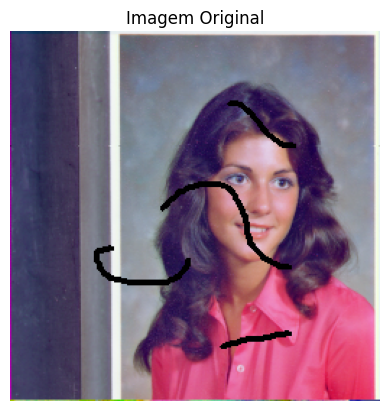

In [7]:
# Carrega a imagem original
image_file = path("imagem")
img = cv2.imread(image_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Exibe a imagem original
print("\n")
plt.imshow(img)
plt.title('Imagem Original')
plt.axis("off")
plt.show()

Prosseguindo, nós temos um while que pergunta se o usuário deseja desenhar uma mascara manualmente, chamando então a função draw anteriormente definida, ou se ele deseja fornecer um arquivo de máscara, após a escolha a imagem e a máscara passam pela função de inpainting e o resultado é por fim exibido em um plot.

Deseja desenhar a máscara manualmente (1) ou fornecer um arquivo (2)? 2
Digite o caminho do arquivo de máscara: /content/imagens/mask1.png




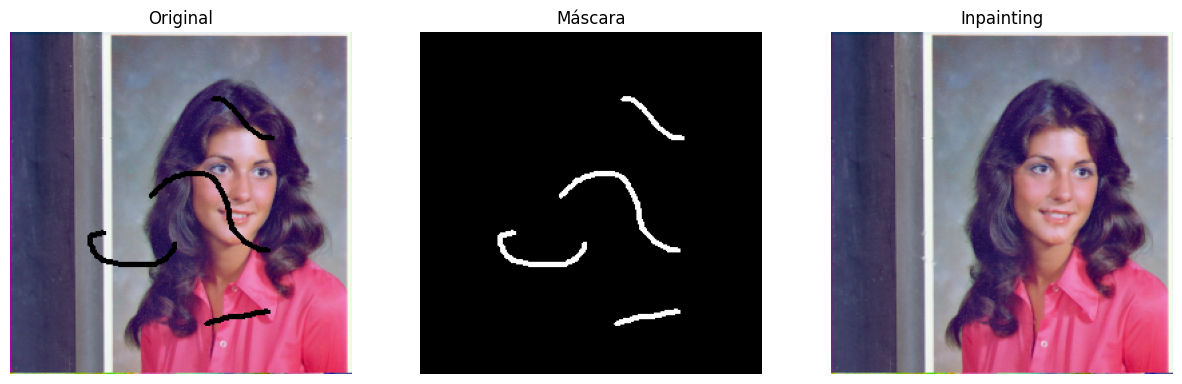

In [8]:
# Loop para captura de erros na entrada de dados
while True:
  # Pergunta se deseja desenhas máscara manualmente ou fornecer um arquivo
  mask_choice = input("Deseja desenhar a máscara manualmente (1) ou fornecer um arquivo (2)? ")
  # Verifica se o valor no input é válido
  if mask_choice == "1" or mask_choice == "2":
    break
  print("Entrada inválida!")

# Essa parte é necessária para exibir uma imagem de referência rgb ao invés de bgr no canvas
# Salva a imagem em um arquivo temporário
temp_file = "./imagens/temp_image.png"
# Converte de BGR para RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Salva imagem processada em arquivo temporário
cv2.imwrite(temp_file, img_rgb)

# Desenha máscara manualmente
if mask_choice == "1":
  print("\n")
  # Abre o arquivo temporário para leitura em bytes
  with open(temp_file, "rb") as f:
      image_bytes = f.read()
      image64 = base64.b64encode(image_bytes)
      image64 = image64.decode('utf-8')

  # Chama a função draw() para desenhar a máscara manualmente
  draw(image64, filename=f"./imagens/temp_image_mask.png", w=img.shape[1], h=img.shape[0], line_width=0.03*img.shape[1])

  # Carrega a imagem da máscara desenhada e converte para um array numpy
  with_mask = np.array(plt.imread(f"./imagens/temp_image_mask.png")[:,:,:3])

  # Cria uma máscara binária a partir da imagem com máscara
  mask = (with_mask[:,:,0]==1)*(with_mask[:,:,1]==0)*(with_mask[:,:,2]==0)
  mask = mask.astype('uint8')

# Fornece arquivo de máscara
elif mask_choice == "2":
  # Pede ao usuário o caminho para o arquivo de máscara
  mask_file = path("máscara")
  print("\n")
  # Converte o arquivo de máscara para escala de cinza
  mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)

# Aplica o inpainting na imagem utilizando a máscara criada
inpaint = cv2.inpaint(img, mask, 2, cv2.INPAINT_TELEA)

# Salva uma cópia da imagem que sofreu inpainting (e passa para rgb)
inpaint_rgb = cv2.cvtColor(inpaint, cv2.COLOR_BGR2RGB)
cv2.imwrite("./imagens/inpaint.png", inpaint_rgb)

# Exibe as imagens
fig, axs = plt.subplots(1, 3, figsize=(15,8));

# Exibe a primeira imagem na plotagem
axs[0].imshow(img, cmap="gray");
axs[0].set_title('Original') ;
axs[0].axis("off");

# Exibe a segunda imagem na plotagem
axs[1].imshow(mask, cmap="gray");
axs[1].set_title('Máscara');
axs[1].axis("off");

# Exibe a terceira imagem na plotagem
axs[2].imshow(inpaint, cmap="gray");
axs[2].set_title('Inpainting');
axs[2].axis("off");

# Exibe as imagens
plt.show()

#### Parte 4 - Implementação da rede neural de Super-Resolution

Assim como no código anterior, esse também começa com um while, porém perguntando se o usuário deseja utilizar a imagem que sofreu inpainting, ou fornecer outra, quando a escolha é efetivada a imagem é então exibida através de um plot e armazenada dentro do upload_folder da rede neural.

Deseja utilizar a imagem que sofreu inpainting (1) ou fornecer outra imagem (2)? 1




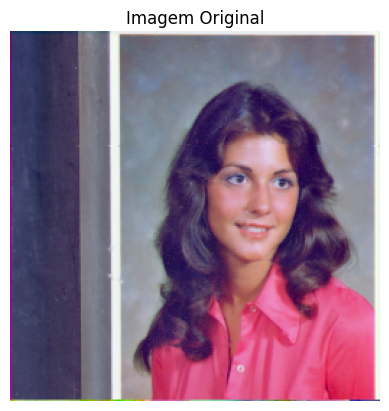

/content/Real-ESRGAN
/content


In [9]:
# Loop para captura de erros na entrada de dados
while True:
  # Pergunta se deseja utilizar a imagem que sofreu inpainting ou fornecer outra imagem
  image_choice = input("Deseja utilizar a imagem que sofreu inpainting (1) ou fornecer outra imagem (2)? ")
  # Verifica se o valor no input é válido
  if image_choice == "1" or image_choice == "2":
    break
  print("Entrada inválida!")

# Escolhe imagem que sofreu inpainting
if image_choice == "1":
  image_file = "/content/imagens/inpaint.png"

# Escolhe outra imagem
elif image_choice == "2":
  image_file = path("imagem")

# Carrega a imagem original
img = cv2.imread(image_file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Exibe a imagem original
print("\n")
plt.imshow(img)
plt.title('Imagem Original')
plt.axis("off")
plt.show()

# Acessa o diretório do Real-ESRGAN (content/Real-ESRGAN)
%cd Real-ESRGAN

# Define os diretórios de upload e results
upload_folder = 'upload'
result_folder = 'results'

# Verifica se os diretórios de upload e result já existem, caso existam, são removidos
if os.path.isdir(upload_folder):
    shutil.rmtree(upload_folder)
if os.path.isdir(result_folder):
    shutil.rmtree(result_folder)

# Cria os diretórios de upload e results
os.mkdir(upload_folder)
os.mkdir(result_folder)

# Copia a imagem escolhida para a pasta upload
shutil.copy(image_file, upload_folder)

# Retorna para o diretório anterior (content)
%cd ..

Proseguindo, essa parte do código roda a rede neural (Real-ERSGAN) na imagem escolhida, podemos adaptar a imagem de saída de acordo com os parametros utilizados na execução do script, como a proposta desse tópico é super-resolução, preferimos prosseguir apenas com esses parametros.

In [12]:
# Acessa o diretório do Real-ESRGAN (content/Real-ESRGAN)
%cd Real-ESRGAN

# Executa o script "inference_realesrgan.py" na imagem passando alguns parâmetros como modelo
!python inference_realesrgan.py -n RealESRGAN_x4plus -i upload --face_enhance --outscale 4

# Parâmetro para aplicar a super-resolução: --outscale 4
# Parametro para melhorar rostos humanos: --face_enhance

# Retorna para o diretório anterior (content)
%cd ..

/content/Real-ESRGAN
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://github.com/xinntao/facexlib/releases/download/v0.1.0/detection_Resnet50_Final.pth" 

Finalizando, essa parte do código é responsável por carregar a imagem tratada com a rede neural dentro da variável superresolution, que é posteriormente exibida junto com sua versão original pelo plot.

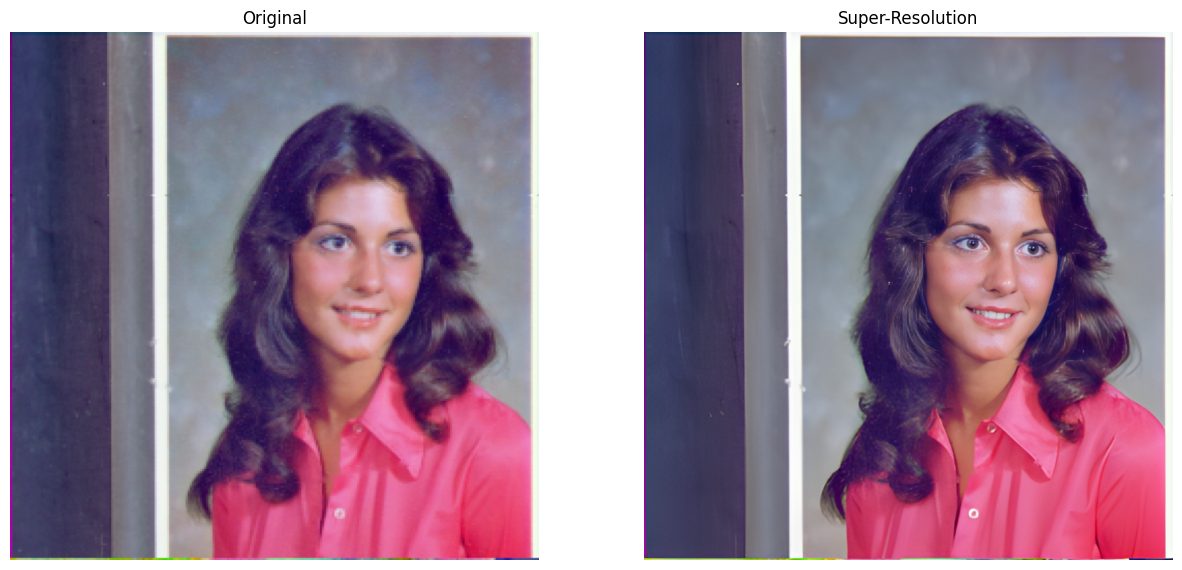

In [13]:
# Carrega a imagem que sofreu super-resolução
superresolution = cv2.imread(glob.glob('/content/Real-ESRGAN/results/*.png')[0])
superresolution = cv2.cvtColor(superresolution, cv2.COLOR_BGR2RGB)

# Exibe as imagens
fig, axs = plt.subplots(1, 2, figsize=(15,8));

# Exibe a primeira imagem na plotagem
axs[0].imshow(img, cmap="gray");
axs[0].set_title('Original') ;
axs[0].axis("off");

# Exibe a segunda imagem na plotagem
axs[1].imshow(superresolution, cmap="gray");
axs[1].set_title('Super-Resolution');
axs[1].axis("off");

# Exibe as imagens
plt.show()

## Conclusão

Resultados obtidos:

* Os resultados obtidos foram satisfatórios, as imagens foram de fato restauradas e melhoradas de forma significativa.
* A rede neural obteve os melhores resultados, produzindo imagens de alta resolução e detalhes precisos.
* Os modelos obtidos contribuiram para a resolução do problema inicial, as técnicas utilizadas possibilitaram recuperar informações perdidas, fazer remoção de objetos das imagens e melhorar a resolução.

Dificuldades:

* Na tentativa de implementar a IA, percebeu-se que algumas redes neurais são incompatíveis com o colab.
* O poder computacional (GPU) do colab é limitado, após algumas interações a rede neural para de funcionar.

Resoluções:

* O uso de redes neurais compatíveis com o ambiente colab.
* Possibilidade de assinar o colab para maior poder computacional, utilizar ambiente de execução local ou alternar as contas do google ao alcançar limite de GPU.

Formas de continuidade:

* Melhorar o canvas da função draw para possibilitar o usuário de corrigir seleções indesejadas na imagem com o atalho crtl+z.
* Implementar o inpainting em tempo real, o usuário seleciona a área e aplica o inpaint ao soltar o click.
* Melhora nas imperfeições que a função do inpaint do OpenCV não é capaz de corrigir, implementando outra rede neural.

## Referências

###Parte 1 - Importação dos dados

1. Importanto/clonando repositórios - https://stackoverflow.com/questions/48350226/methods-for-using-git-with-google-colab.
2. Documentação do OpenCV - https://docs.opencv.org/4.x/.
3. Documentação do IPython - https://ipython.readthedocs.io/en/stable/.
4. Documentação do Base64 - https://docs.python.org/3/library/base64.html.
5. Como utilizar js no notebook - https://colab.research.google.com/notebooks/snippets/advanced_outputs.ipynb.
6. Documentação do Matplotlib - https://matplotlib.org/3.5.3/api/_as_gen/matplotlib.pyplot.html.
7. Documentação do Numpy - https://numpy.org/doc/1.23/numpy-ref.pdf.
8. Documentação do Shutil - https://docs.python.org/3/library/shutil.html.
9. Documentação do Glob - https://docs.python.org/3/library/glob.html.
10. Documentação da rede neural Real-ESRGAN - https://github.com/xinntao/Real-ESRGAN/blob/master/README.md.

###Parte 2 - Implementação do canvas e das funções

11. Como utilizar o canvas - https://developer.mozilla.org/pt-BR/docs/Web/API/Canvas_API/Tutorial.
12. Como tratar erros com try e except - https://www.hashtagtreinamentos.com/try-e-except-no-python.

###Parte 3 - Implementação do Inpainting

13. Como utilizar a função inpaint - https://docs.opencv.org/3.4/df/d3d/tutorial_py_inpainting.html.

###Parte 4 - Implementação da rede neural de Super-Resolution

14. Manipulando diretórios com Shutil - https://code-maven.com/slides/python/os-dir.